# __Spherical harmonic transform__ 
---

[![colab image](https://colab.research.google.com/assets/colab-badge.svg)](https://colab.research.google.com/github/astro-informatics/s2fft/blob/main/notebooks/spherical_harmonic_transform.ipynb)

In [1]:
import sys
IN_COLAB = 'google.colab' in sys.modules

# Install a spherical plotting package.
!pip install cartopy &> /dev/null

# Install s2fft and data if running on google colab.
if IN_COLAB:
    !pip install s2fft &> /dev/null
    !mkdir data/
    !wget https://github.com/astro-informatics/s2fft/raw/main/notebooks/data/Gaia_EDR3_flux.npy -P data/ &> /dev/null

This tutorial demonstrates how to use `S2FFT` to compute spherical harmonic transforms. Specifically, we will adopt the sampling scheme of [McEwen & Wiaux (2012)](https://arxiv.org/abs/1110.6298). 

First let's load an input signal that is sampled on the sphere with this sampling scheme.

In [2]:
import jax
jax.config.update("jax_enable_x64", True)

import numpy as np
from matplotlib import pyplot as plt 
import cartopy.crs as ccrs 
import s2fft 

sampling = "mw"
f = np.load('data/Gaia_EDR3_flux.npy')
L = f.shape[0]

Lets look at the input signal

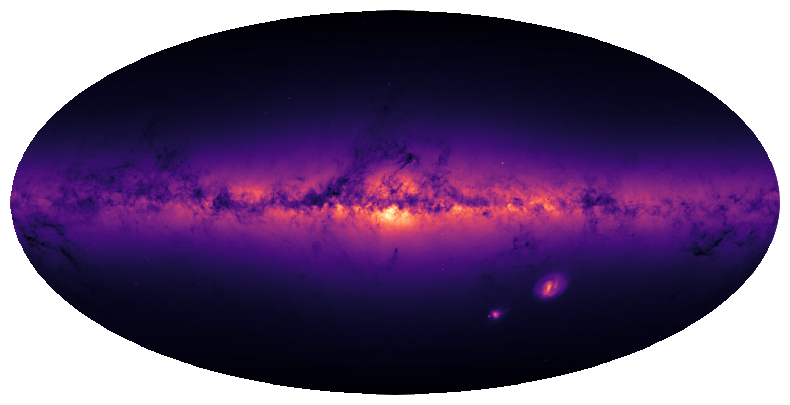

In [3]:
plt.figure(figsize=(10,5))
ax = plt.axes(projection=ccrs.Mollweide())
im = ax.imshow(f, transform=ccrs.PlateCarree(), cmap='magma')
plt.axis('off')
plt.show()

### Computing the forward spherical harmonic transform

---

Let's now run the JAX function to compute the spherical harmonic transform of this map.

In [4]:
flm = s2fft.forward_jax(f, L)

If you are planning on applying this transform many times (e.g. during training of a model) we recommend precomputing and storing some small arrays that are used every time.  This trades off additional memory usage for enhanced speed and should be fine at small and moderate bandlimits `L`.

To do this simply compute these and pass as a static argument.

In [5]:
precomps = s2fft.generate_precomputes_jax(L, forward=True)
flm_pre = s2fft.forward_jax(f, L, precomps=precomps)

### Computing the inverse spherical harmonic transform

---

Let's run the JAX function to cmpute the inverse spherical harmonic transform to get back to the input map.

In [6]:
f_recov = s2fft.inverse_jax(flm, L)

Again, if you are planning on applying this transform many times we recommend precomputing and storing some small arrays that are used every time. Recall, this trades off additional memory usage for enhanced speed and should be fine at small and moderate bandlimits `L`.

To do this simply compute these and pass as a static argument.

In [7]:
precomps = s2fft.generate_precomputes_jax(L, forward=False)
f_recov_pre = s2fft.inverse_jax(flm_pre, L, precomps=precomps)

### Computing the error

---

Let's check the associated error, which should be close to machine precision for the sampling scheme used.

In [8]:
print(f"Mean absolute error = {np.nanmean(np.abs(f_recov - f))}")

Mean absolute error = 4.2087117836623753e-13


In [9]:
print(f"Mean absolute error using precomputes = {np.nanmean(np.abs(f_recov_pre - f))}")

Mean absolute error using precomputes = 4.2087117836623753e-13
